# Description
This is a model which can create coupled networks of a desired type and change their parameters to observe which of them affect synchronization. 

It carries out the following functions:
    1. Create individual network groups with their synapses --> uses BrianVis.network_indv(...)
    2. Create synapse group of coupled networks with monitors to record each network --> BrianVis.network_coupling(..)
    3. Make changes to individual parameters of network groups, synapses and run times
    4. Run the coupled networks in the following pattern:
               a. Disconnected networks for a time t1*s: coupled synaptic weights will be zero
               b. Connected(coupled) networks for a time t2*s: coupled synaptic weights reset to values obtained in step 2
               c. Disconnected networks for a time t1*s: coupled synaptic weights set to zero again
    5. Output spikemonitor voltages and times so they can be graphed

# Goals:
- To simulate coupled networks while varying their parameters
- To observe network behavior in coupled vs uncoupled states

## Importing Python Modules

In [1]:
# Please make sure kernel is Python 2 and not Python 3. 
# Currently Brian 2 does not work correctly on Python3 even if the package is installed
# Refer to README file on GitHub for how to change the Jupyter notebook environment to Python2
# Refer to README file on GitHub for how to setup PySpike

import networkx as nx
from brian2 import *
import numpy as np
import time
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
#import pyspike as spk
%matplotlib inline

In [2]:
from lib.SynchronicityCalculation import SynchronicityCalculation
from lib.Visualization import Visualization
from lib.BrianVisualization import BrianVisualization
from lib.Spike_Stats import Spike_Stats
from lib.AdjacencyMatrix import AdjacencyMatrix

## Defining Classes

### Types: 
* Visualization
* Brian Visualization
* Adjacency Matrix
* Spike Stats
* Synchronicity Calculation

## Initializing Classes

In [3]:
# Initializing classes
t_start = time.time()
sync = SynchronicityCalculation()
vis = Visualization() 
BrianVis = BrianVisualization()
stats = Spike_Stats()

## Defining Input Parameters

In [4]:
# Define network parameters

'''
Network Architecture Variables:
    n - number of nodes/neurons
    p1 - for Network 1, probability for an edge to be formed between two nodes
    p2 - for Network 2, probability in a small-world network  
    k - each node is connected to k nearest neightbors
    rand_seed - method of generating a random number, in this case, one based on time
    excit - number of excitatory neurons
    inhib - number of inhibitory neurons
'''
n = 100
p1 = 0.5
p2 = 0.5 
k = 2
rand_seed = np.random.seed(int(time.time())) # To seed random number generator based on time
excit = int(0.8*n) # 80% of total neurons
inhib = int(0.2*n)

'''
Network Simulation Variables:
    N: number of neurons
    tau_m: time constant (ms)
    v_r: reset membrane potential (mv)
    v_th: threshold membrane potential (mv)
    I_c: external depolarizing current that is constant
    run_time: simulation time (ms)
    p_couple: probability that neuron i in first net will couple with neuron i in second net
    w_couple: synaptic weight in (V) for connections between sub-networks or between different network groups
    PInput: Poisson Input - weight = 0 for off and 0.1 for on
    integ_method: method of integration for solving differential equations of neuron dynamics
    bin_size: time window to sample spike train data (ms) eg. counting spikes within a certain time interval
'''
N = n 
v_r = 0*volt
v_th = 1*volt  
p_couple = 0.5 #0.99
w_couple = 1*volt # Overwritten Later 
PInput = 0.1*volt # This means Poisson input is on and is applied to both networks
integ_method = 'heun' # or can use 'linear' if differential equation is linear, or euler(non-linear integration)
                       # or heun (improved or modified euler method)
bin_size = 1 # do NOT add units here. It will be added in Stats class under spike_bin function

run_time = 1000 # units in ms
t1 = run_time*0.2 # 20% of runtime will be in the uncoupled state at the beginning and end 
t2 = run_time*0.6 # 60% of runtime will be in the coupled state
phase1 = int(t1)
phase2 = int(t1+t2)
phase3 = int(t2+2*t1)

'''
Individual Neuron dynamics:
    E_l = leakage potential to account for the exchange of all other ions across cell membrane
    dia = diameter of post-synaptic surface
    length = length of post-synaptic surface
    SA = surface area of post-synaptic neuron
    gL = conductance of leakage channels
    C_mem = membrane capacitance
    E_ex = reversal potential of excitatory synaptic potential eg. AMPA
    E_i = reversal potential of inhibitory synaptic potential eg. GABA 
    tau_ge = time constant for signal to go through excitatory synapse
    tau_gi_c = time constant for signal to go through inhibitory synapse, same(constant) value applied to all neurons
    tau_gi_var = time constant for signal to go through inhibitory synapse, different(variable) value applied to each neuron
    v_c: starting voltage(constant) for all neurons in a neuron group before simulation
    connect_type: 'ee', 'ii', 'ei','ie'
    neuron_diffeqns: neural model for individual neurons, this is a string of differential equations
'''

E_l = -90*mV
dia = 20*um
length = 20*um
SA = (2*pi*(dia/2)*length) # units are um2
gL = 1*psiemens/um2 * SA # units are psiemens
C_mem = 10e-6*farad/cm2 * SA # units are farad
E_ex = 0*mV
E_i = -80*mV 
v_c = 0*volt
I_c = 1000 # same as I_ext, units pamp
tau_ge = 2*ms
tau_gi_c = 6.8 # units of ms
connect_type = 'ee'

# Defining variable parameters using functions in the SynchronicityCalculation class
tau_gi_var = sync.sync_parameter(tau_gi_c,1,n)*ms
I_var = sync.sync_parameter(I_c,1,n)*pamp

model_2 = '''
dv/dt = (1/C_mem)*(ge*(v - E_ex) + gi*(v - E_i) + gL*(v - E_l) + I) : volt (unless refractory)
dge/dt = -ge/tau_ge : siemens
dgi/dt = -gi/tau_gi : siemens
I : ampere
tau_gi : second
'''

# Specify which neural model to simulate with
neuron_diffeqns = model_2    

## Creating Individual Network Structure
Two small-world networks are created using the following parameters:
* n, number of neurons in the network 
* p, probablity of a synapse to form between two neurons
* k, number of nearest neighbours each neuron is connected to

In [5]:
### Creating two small-world networks and their corresponding adjacency matrices

'''
A1: Adjacency Matrix for a small world network (Network 1), n by n with 1's for a connection and 0's for none
A2: Adjacency Matrix for a small world network (Network 2)
Graph1: Network object specifying nodes and edges of network architecture for Network 1
connect_A1: the unweighted version of connect_W, a 1-D array of excitatory(1) and inhibitory(-1) connections
new_coord1: pairs of source and target neurons which are in order and no duplicate pairs
new_rows1: 1-D array of all source neurons
new_cols1: 1-D array of all target neurons
'''

Adj = AdjacencyMatrix(n) # Initiates an instance of AdjacencyMatrix class

# Network 1: Small World
[A1,Graph1] = Adj.small_world(n,k,p2) # Defines random topology using nodes, n and probability, p
                        # NetworkX used to generate random graph topography
                        # Creates adjacency matrix. For indexes, rows: source neurons, columns: target neurons. 
                        # 1s indicate nodes connected by an edge, 0s for the opposite

# To produce an adjacency matrix with weights adjusted according to excitatory(+ve weight) or inhibitory synapse(-ve weight)
[connect_A1,new_coord1,new_rows1,new_cols1] = Adj.adj_synapse_type(A1,excit)

# Network 2: Small World
# Same process as for Network 1
[A2,Graph2] = Adj.small_world(n,k,p2)
[connect_A2, new_coord2,new_rows2,new_cols2] = Adj.adj_synapse_type(A2,excit)

connect_W1 = np.multiply(connect_A1,np.random.uniform(0,1,len(connect_A1)))*volt
connect_W2 = np.multiply(connect_A2,np.random.uniform(0,1,len(connect_A2)))*volt


For small-world network 1, the clustering co-efficient is 0.0
For small-world network 2, the clustering co-efficient is 0.0203333333333


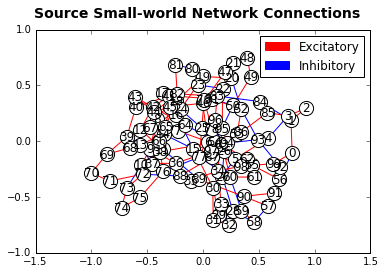

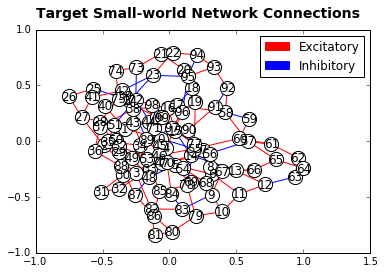

In [6]:
### Using functions in the Visualization class

cluster = vis.cluster_coeff(Graph1)
print ("For small-world network 1, the clustering co-efficient is"), cluster

# Clustering coefficient for Network 2
cluster = vis.cluster_coeff(Graph2)
print ("For small-world network 2, the clustering co-efficient is"), cluster

vis.ex_in_connec(Graph1,connect_A1,new_coord1) # This function also uses new_coord returned from AdjacencyMatrix class, 
                                               # adj_synapse_type func
suptitle('Source Small-world Network Connections', fontsize=14, fontweight='bold')
    
vis.ex_in_connec(Graph2,connect_A2,new_coord2)
suptitle('Target Small-world Network Connections', fontsize=14, fontweight='bold')

# Batch Simulation: Varying (p_couple, w_couple)

In [7]:
def batch_heatmap(coeff):
    # Plotting heat map using correlation coefficients obtained above. Will make this a separate function titled batch_vis
    fig = plt.figure(figsize=(8,8))
    plt.title("Correlation coefficients of coupled Network 1 and 2")
    map = plt.imshow(coeff,cmap = 'RdYlBu_r',vmin=-1,vmax=1,origin='lower') # Blue gives maximum correlation while red shows least correlation
    plt.colorbar(map) # To show the legend of colors with corresponding values form matrix  
    plt.xlabel('Synaptic strength factor')
    plt.ylabel('Coupling probability')
    plt.xticks(np.arange(0, w_len),w_couple_vec/volt)
    plt.yticks(np.arange(0, p_len),p_couple_vec)

In [8]:
def batch_plot(datastream, index):
    inds2 =[0,1,2,3,4]
    SN1t,SN1i,SN2t,SN2i,SN0t = [datastream[index][j] for j in inds2]
    h = 0.4
        
    # Plot target PSTH (top graph)
    fig2 = plt.figure()
    ax3 = fig2.add_axes([0.1, 0.2, 1.5, h])
    my_bins = arange(0,run_time+2,2)
    ax3.hist(SN2t/ms, bins=my_bins)
    plt.margins()
    xlabel('Time (ms)')
    ylabel('Network 2: Total spikes')
    
    # Creating multi-raster plot
    fig1 = plt.figure()

    # Setting up target network axes (red)
    ## adjusting axes with the format: [left, bottom, width, height]
    ax1 = fig1.add_axes([0.1, 0.6, 1.5, h], ylim=(0, n), xlim = (0,run_time))
    ax1.set_title('Coupling of Two Small World Networks\n with p= %.2f and w =%.2f' %(record_param[index][1], record_param[index][0]))            
    ax1.set_xticks([])

    plt.axvline(x = phase1,color='k',linewidth=3.0)
    plt.axvline(x = phase2,color='k',linewidth=3.0)
    plt.axvline(x = phase3,color='k',linewidth=3.0)

    ylabel('Network 2')

    # Setting up source network axes (green)
    ax2 = fig1.add_axes([0.1, 0.2, 1.5, h], ylim=(0, n), xlim = (0,run_time))

    plt.axvline(x = phase1,color='k',linewidth=3.0)
    plt.axvline(x = phase2,color='k',linewidth=3.0)
    plt.axvline(x = phase3,color='k',linewidth=3.0)

    ylabel('Network 1')
    xlabel('Time (ms)') 

    # Plot source PSTH (bottom graph)
    fig2 = plt.figure()
    ax3 = fig2.add_axes([0.1, 0.6, 1.5, h])
    my_bins = arange(0,run_time+2,2)
    ax3.hist(SN1t/ms, bins=my_bins)
    plt.margins()
    #xlabel('Time (ms)')
    ylabel('Network 1 spikes')
    
    ax4 = fig2.add_axes([0.1, 0.1, 1.5, h])
    my_bins = arange(0,run_time+2,2)
    ax4.hist(SN0t/ms, bins=my_bins)
    plt.margins()
    xlabel('Time (ms)')
    ylabel('Uncoupled Network spikes')
    
    # Plotting both raster plots
    ax1.plot(SN2t/ms, SN2i, '.r'); # target or slave network
    ax2.plot(SN1t/ms, SN1i, '.g'); # source or master network

28.125

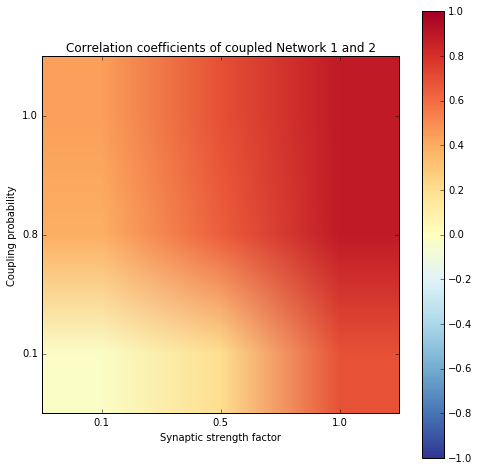

In [20]:
# Batch simulation program
t3 = time.time() # Record start time

# Set simulation parameters
# cf = [0.01, 0.05, 0.5, 0.8, 1.0, 3.0, 7.0, 10.0, 15.0, 20.0]*volt
# p_couple_vec = np.arange(0.1,1.1,0.1)

cf = [.1,.5,1] # shorter parameters for testing
p_couple_vec = [0.1,0.8,1.0] # shorter parameters for testing

w_couple_vec = w_couple*cf
w_len = len(w_couple_vec)
p_len = len(p_couple_vec)
coeff = np.zeros((p_len,w_len))

# provide a set of values (w_couple,p_couple) to record spikemonitor values for plotting and analysis
#record_param = [(0.05,0.5),(20.0,0.5),(1.0,0.1),(1.0,0.9)]
record_param = [(.1,0.1),(.5,0.8),(1,0.8),(1,1.0)]
datastream = [None]*len(record_param)

# Creating individual network groups
# PInput define in the input section is 'off' if = 0*volt and 'on' otherwise
PInput = 0*volt
[G1,S1,P1] = BrianVis.network_indv(new_rows1,new_cols1,connect_W1,N,PInput,'neurongroup_1','synapsegroup_1',neuron_diffeqns,integ_method,v_c)
[G2,S2,P2] = BrianVis.network_indv(new_rows2,new_cols2,connect_W2,N,0.1*volt,'neurongroup_2','synapsegroup_2',neuron_diffeqns,integ_method,v_c)
[G3,S3,P3] = BrianVis.network_indv(new_rows1,new_cols1,connect_W1,N,PInput,'neurongroup_3','synapsegroup_3',neuron_diffeqns,integ_method,v_c)

#_____________________________________________________
# Set parameters for Network 1
G1.tau_gi = tau_gi_var # making network 1 slower than network 2 for entrainment
G1.I = I_var*1000

# Set parameters for Network 2
G2.tau_gi = tau_gi_var/2
G2.I = I_var

# Set parameters for Network 3
G3.tau_gi = tau_gi_var # making network 1 slower than network 2 for entrainment
G3.I = I_var*1000
#______________________________________________________

# Setting up network groups and spike monitors for simulation
net_batch = Network(G1,P1,S1,G2,P2,S2,)
net_batch.store() # store values of Networks 1 and 2 so they be restored at the end of each run before the next one begins
spikemon_indv = SpikeMonitor(G3, variables='v',name='spikemon_indv')
net_indv = Network(G3,P3,S3,spikemon_indv)
net_indv.store() # store values of Networks 3 so it can be restored at the end of each run before the next one begins

for weight in arange(w_len):
    for prob in arange(p_len):
        '''
        In every for loop neuron groups for Network 1 and 2 are created again using preset connectivity matrix and 
        neuron model equations. Using new coupling synaptic weight and coupling probability, a new coupling synapse group
        is also created. The network group 'net_batch' is declared with Network objects and only these objects are
        simulated during runtime
        '''
        # running the full simulation for uncoupled Network 1 as a control
        net_indv.run(run_time*ms)
        states_indv = net_indv.get_states()
        SN_indvt = states_indv['spikemon_indv']['t']
        
        # Coupling networks and setting up network groups for simulation
        [statemon_cG1,spikemon_cG1,statemon_cG2,spikemon_cG2,G1c2_rows,G1c2_cols,G1c2_coup_mat,S1c2] =\
        BrianVis.network_coupling(N,excit,inhib,p_couple_vec[prob],w_couple_vec[weight],G1,G2,'Synapse_1c2',connect_type)
        net_batch.add(S1c2,spikemon_cG1,spikemon_cG2)
        
        # run 3 phase simulation - for proof of concept
        ## 1. To begin simulation, set inter-network synaptic weights to 0. i.e. networks are not connected
        ## 2. Run simulation for the first t1*ms
        
        S1c2.w = 0
        net_batch.run(t1*ms)

        ## 3. Re-establish synaptic connections
        ## 4. Run simulation for the next t2*ms
        
        S1c2.w = w_couple_vec[weight]
        net_batch.run(t2*ms)

        ## 5. Remove synaptic connections again
        ## 6. Run simulation for the last t1*ms 
        S1c2.w = 0
        net_batch.run(t1*ms)
        
        states = net_batch.get_states()
        SN_1i = states['spikemon_cG1']['i']
        SN_1t = states['spikemon_cG1']['t']
        SN_2i = states['spikemon_cG2']['i']
        SN_2t = states['spikemon_cG2']['t']

        # obtaining correlation coefficient from comparing binary spike trains of Network 1 and 2
        c = stats.batch_cc(SN_1t,SN_2t,phase1,phase2,bin_size)
        coeff[prob,weight] = c
        
        # for loop to record spikemonitor data for selected runs that need to be graphed
        for k in arange(len(datastream)):
            if record_param[k]==(w_couple_vec[weight]/volt,p_couple_vec[prob]): # check if correct run is 
                                                                                # one that needs to be recorded
                # store a copy of all spike monitors at this instance (for the current run) by returning a dictionary 
                # using 'spikemonitor'.spike_trains() Brian function and reformatting it as an array of sorted spike times              
                
                datastream[k] = (SN_1t,SN_1i,SN_2t,SN_2i,SN_indvt)
            
        net_batch.remove(S1c2,spikemon_cG1,spikemon_cG2)
        net_batch.restore() # go back to original network state with initial values of Network 1 and 2
        net_indv.restore() # go back to original network state with initial values of Network 3       
    
batch_heatmap(coeff) # plot a probability of coupling vs synaptic strength heatmap using a matrix of 
                     #  correlation coefficients

t4 = time.time() # to keep track of batch simulation time
t4-t3

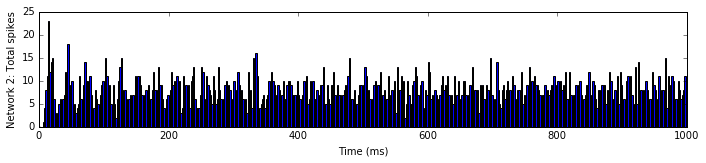

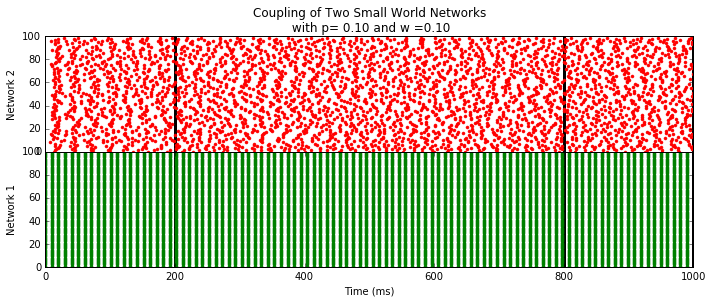

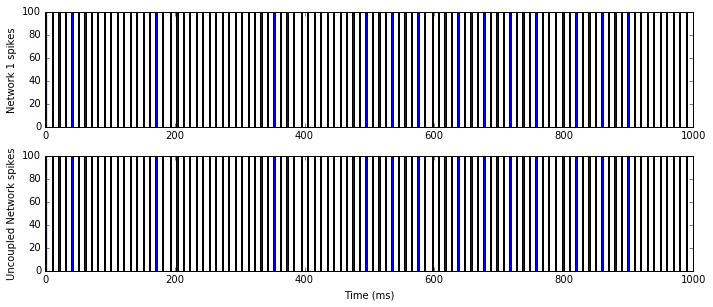

In [21]:
batch_plot(datastream,0)

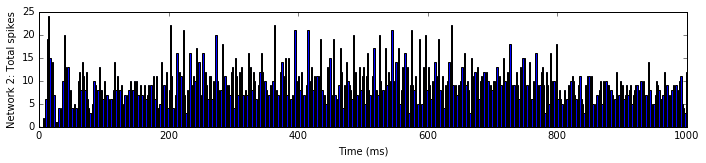

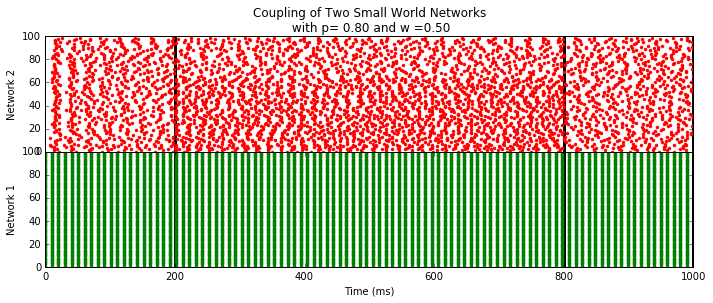

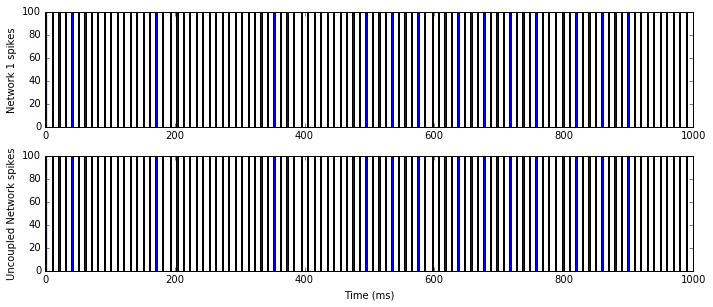

In [22]:
batch_plot(datastream,1)

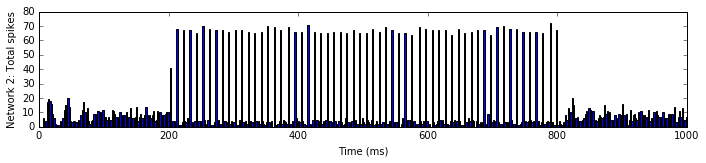

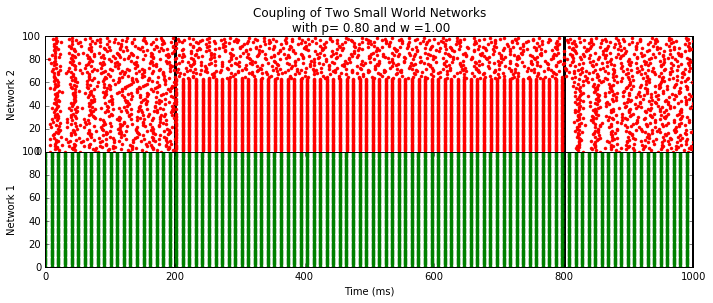

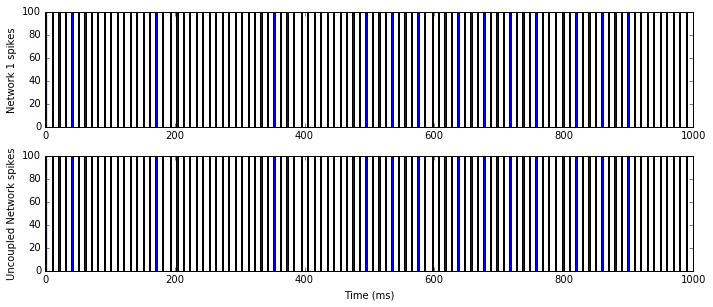

In [23]:
batch_plot(datastream,2)

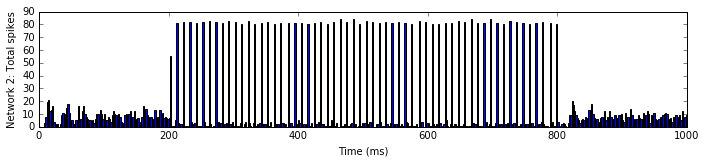

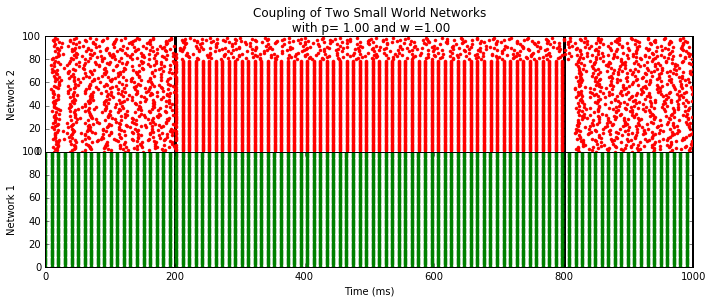

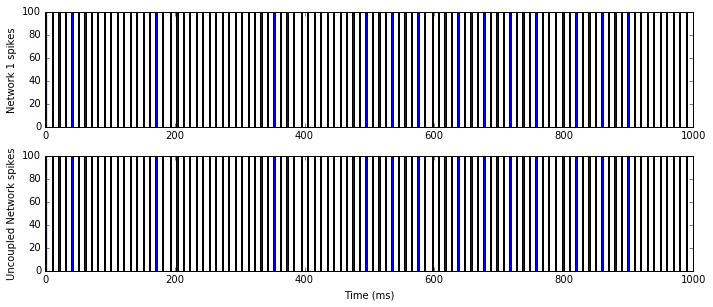

In [24]:
batch_plot(datastream,3)